# Mining Unexpected Concepts
---
Wikivitals

**Libraries**

In [564]:
from collections import defaultdict, Counter
from contextlib import redirect_stdout
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import random
import seaborn as sns
from scipy import sparse, special

from sknetwork.data import load_netset, from_edge_list
from sknetwork.utils import get_degrees, get_membership, get_neighbors
from sknetwork.ranking import top_k
from sknetwork.topology import Triangles, Cliques, get_connected_components
from sknetwork.visualization import svg_graph

## Data

In [2]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [3]:
adjacency = wikivitals.adjacency
biadjacency = wikivitals.biadjacency
names = wikivitals.names
words = wikivitals.names_col
labels = wikivitals.labels

In [4]:
names

array(['0', '1', '100 metres', ..., 'Łódź', 'Śāriputra', '−1'],
      dtype='<U62')

In [5]:
words[:10]

array(['Alexis', 'Cairo', 'subordinate', 'marching', 'bengali', 'Adal',
       'pulvinus', 'Gallia', 'Harris', 'Toshiro'], dtype='<U26')

## Algorithm

In [324]:
def plot_distrib(values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')
    
def mdl_graph(adjacency):
    n = adjacency.shape[0]

    # density
    #d = np.sum(adjacency) / (n * (n - 1))
    
    # nodes
    nodes_mdl = np.log2(n)
    
    # edges
    degrees = adjacency.dot(np.ones(n))
    max_degree = np.max(degrees)
    edges_mdl = (n + 1) * np.log2(max_degree + 1) + np.sum([np.log2(special.comb(n, deg)) for deg in degrees])

    return (nodes_mdl + edges_mdl)

def entropy(prob):
    return prob * -np.log2(prob)

def desc_complexity(attrs):
    if isinstance(attrs, int):
        attrs = [attrs]
    prob = 1
    for attr in attrs:
        prob *= degrees[attr] / np.sum(degrees)
    entr = entropy(prob)
    return generation_complexity(biadjacency.shape[1], len(attrs)) * entr

In [282]:
def in_close(adjacency, context, extents, intents, unexs, unexs_g, r, y, degs, gain, verbose):
    
    support_obj = 5
    support_attr = 15
    delta = 5
    
    global gain_unex
    # --------------------
    
    global r_new
    r_new = r_new + 1
    attributes = np.arange(0, context.shape[1])
    
    for n_iter, j in enumerate(attributes[y:]):
        
        try:
            extents[r_new] = []
            unexs[r_new] = 0
            unexs_g[r_new] = 0
        except IndexError:
            extents.append([])
            unexs.append(0)
            unexs_g.append(0)

        # Form a new extent by adding extension of attribute j to current concept extent
        extension_j = get_neighbors(context, node=j, transpose=True)
        new_extent = np.array(list(set(extents[r]).intersection(set(extension_j))))
        extents[r_new] = new_extent
        new_extent_size = len(new_extent)
        
        # Verify that intention
        len_closure = 0
        if len(new_extent > 0):
            all_neighbs = set(get_neighbors(context, node=new_extent[0]))
            for o in new_extent[1:]:
                neighbs = get_neighbors(context, node=o)
                all_neighbs &= set(neighbs)
            len_closure = len(all_neighbs)
        
            
        if len_closure >= support_obj:
            #if verbose:
            #    print(f'closure of {new_extent} --> size of closure = {len_closure}>{support_obj}')
            
            
            if new_extent_size >= support_obj:
                if verbose:
                    print(f'n_iter:{n_iter} - extents: {extents[r]} - intents: {intents[r]}')
                    print(f'  Candidate attr: {j} {sorted_names_col[j]}')
                    print(f'  new extent: {new_extent}')

                #if new_extent_size < len(extents[r]):
                # Graph unexpectedness
                g_r_new = adjacency[new_extent][:, new_extent]
                complexity_desc_g = mdl_graph(g_r_new)
                complexity_gen_g = np.mean(complexity_gen_graphs.get(new_extent_size))
                unex_g = complexity_gen_g - complexity_desc_g
                unexs_g.append(unex_g)
                if verbose:
                    print(f'  U(G)={unex_g} (cw={complexity_gen_g} - c={complexity_desc_g})')

                new_intent = np.array(list(sorted(set(intents[r]).union(set([j])))))
                new_intent_size = len(new_intent)            

                if new_intent_size <= support_attr:

                    # Attributes unexpectedness
                    complexity_gen_a = np.log2(special.comb(context.shape[1], new_intent_size))
                    complexity_desc_a = 0
                    for a in new_intent:
                        complexity_desc_a += np.log2(degs[a])
                    unex_a = complexity_gen_a - complexity_desc_a
                    if verbose:
                        print(f'  U(A)={unex_a} (cw={complexity_gen_a} - c={complexity_desc_a})')

                    # Total Unexpectedness
                    unex = unex_g + unex_a
                    if verbose:
                        print(f'  U: {unex}')
                    unexs[r_new] = unex

                    if verbose:
                        print(f'  U[r_new]={unex} - U[r]={unexs[r]}  = {unex - unexs[r]}')

                    gain_unex.append(unex - unexs[r])
                    if verbose:
                        print(f'  gain unex: {gain_unex}')
                        print(f'  Gain unex diff: {np.abs(gain_unex[-2]-gain_unex[-1])}')

                    if new_extent_size == len(extents[r]):

                        #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                        if (len(intents[r]) == 0) or ((unex - unexs[r] > 0) and (np.abs(gain_unex[-2] - gain_unex[-1])) > delta):
                            intents[r] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                            extents[r] = extents[r_new]
                            unexs_g[r] = unex_g
                            unexs[r] = unex
                            if verbose:
                                print(f'  Attribute {j}-{sorted_names_col[j]} added')
                        else:
                            if verbose:
                                print(f'  unex - unexs[r] > 0 : {(unex - unexs[r] > 0)}')
                                print(f'  (gain_unex[-2] - gain_unex[-1]) > delta : {(gain_unex[-2] - gain_unex[-1]) > delta}')
                                print(f'  len(intents[r]) == 0 : {len(intents[r]) == 0}')
                                print(f'  --> Stop branch recursion. ')
                                print('\n')

                            #del gain_unex[(r_new-r):]
                                if len(intents[r]) > 1:
                                    del gain_unex[-(len(intents[r]))+1:]
                                else:
                                    del gain_unex[-(len(intents[r])):]

                            return [*zip(extents, intents)]

                    else:
                        #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                        if (len(intents[r]) == 0) or (unex - unexs[r] > 0):

                            try:
                                intents[r_new] = []
                            except IndexError:
                                intents.append([])

                            intents[r_new] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                            if verbose:
                                print('  recursive call')
                            in_close(adjacency, context, extents, intents, unexs, unexs_g, r=r_new, y=j+1, degs=degs, gain=gain_unex, verbose=verbose)
                        else:
                            if verbose:
                                print(f'  Do not go into recursion. Try next candidate attribute. ')
                                print()
                            gain_unex.pop(-1)
                else:
                    if verbose:
                        print(f'Max number of attributes reached.')
                        print('\n')
                    return [*zip(extents, intents)]

            #else:
            #    if verbose:
            #        print(f'  New extent size >= support? : {new_extent_size >= support_obj}')
            
        #else:
            #if verbose:
                #    print(f'closure of {new_extent} --> no need to verify all attributes')
    if verbose:
        print('\n')
        

    if len(intents[r]) > 1:
        del gain_unex[-(len(intents[r]))+1:]
    else:
        del gain_unex[-(len(intents[r])):]
    return [*zip(extents, intents)]

## Application

### Minimum Description Lengths of random graphs  

Build a dictionary of MDL for random graphs with varying number of nodes and density.

In [8]:
# Density of initial graph
n, m = adjacency.shape[0], adjacency.nnz
density = (m) / (n * (n - 1))
density

0.008232692290229

In [162]:
%%time
complexity_gen_graphs = defaultdict(list)

for num_n in range(adjacency.shape[0] + 1)[3:1000]:
    cpt = 0
    while cpt < 3:
        random_g = sparse.random(num_n, num_n, density=0.5).astype(bool).tocsr()
        if random_g is not None and random_g.shape[0] == num_n:
            mdl = mdl_graph(random_g)
            complexity_gen_graphs[num_n].append(mdl)
            cpt += 1

CPU times: user 1min 39s, sys: 2.73 s, total: 1min 42s
Wall time: 1min 42s


In [163]:
#import pickle
#f = open("complexity_gen_graphs.pkl", "wb")
#pickle.dump(complexity_gen_graphs, f)
#f.close()

In [283]:
# In-close initialization
V = np.arange(0, biadjacency.shape[0])
extents, intents, unexs, unexs_g = [], [], [], []
extents_init = V
intents_init = []
unexs.append(0)
unexs_g.append(0)
extents.append(extents_init)
intents.append(intents_init)

In [284]:
global r_new
r_new = 0
global gain_unex
gain_unex = []
gain_unex.append(0)

n_objects_min = 5
n_objects_max = 999

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= n_objects_max) & (freq_attribute >= n_objects_min))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
sort_index = np.argsort(freq_attribute)
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

In [285]:
%%time

with open('logs/log_wikivitals.txt', 'w') as f:
    with redirect_stdout(f):
        result = in_close(adjacency, filt_biadjacency, extents, intents, unexs, unexs_g, r=0, y=0, degs=sorted_degs, gain=gain_unex, verbose=True)
        print()

CPU times: user 1h 19min 35s, sys: 13min 45s, total: 1h 33min 20s
Wall time: 1h 50min 18s


In [306]:
# Save result
with open("result/result.bin", "wb") as output:
    pickle.dump(result, output)

In [307]:
# Load result
#with open("result/result.bin", "rb") as data:
#    myList = pickle.load(data)

### Results

In [437]:
print(f'Number of concepts: {len(result)}')

Number of concepts: 350


In [619]:
# Some concepts
print(f'Attributes | Nodes')
rand_idx = np.random.choice(len(result), 10)
for i in rand_idx:
    concepts = result[i]
    print(f'{str(concepts[1]):<25} {concepts[0]}')

Attributes | Nodes
[469]                     [9249 4131 4901 8790 1081]
[ 4786 13291]             [ 515 5577 5486 1714 9334]
[1605]                    [1793 4905 3276 2065 5913]
[ 6054 11304 14907 15131] [5889 5538 9804 5233 4948  924]
[3704]                    [6149  877 7311 6196 2325 9720]
[ 4780 11627 15765]       [4675 1480  272  755 4474]
[ 2459 17842]             [3975 4823 5432 1405 5023]
[ 5508 12913 13296 14933] [6900 2964  283 7773 4766 5883]
[2726]                    [9600 6310 6220  561 4977 8440]
[5443 9532]               [5893 3077 5360 6900 2964 2134  283 7773]


**Summarized graph for one specific node**

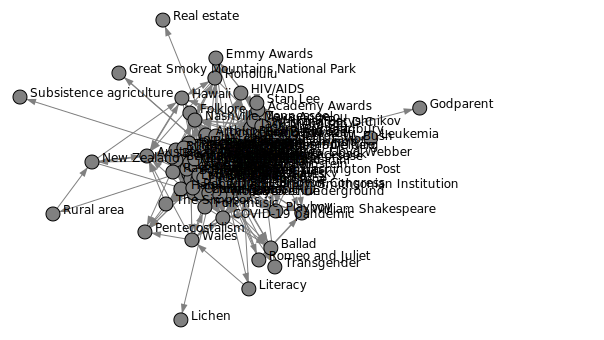

In [463]:
# 2471 and its neighbors in orginial graph
nei = np.concatenate((get_neighbors(adjacency, node=2471), np.array([2471])))
SVG(svg_graph(adjacency[nei, :][:, nei], names=names[nei]))

In [461]:
# 2471 and its neighbors in summarized graph
summarized_nodes = set()
for c in result:
    if 2471 in c[0] and len(c[1]) > 0:
        summarized_nodes |= set(c[0])
    
summarized_nodes = np.concatenate((np.array(list(summarized_nodes)), np.array([2471])))
summarized_nodes

array([2471, 5418, 3436, 1461, 3543,  893, 2471])

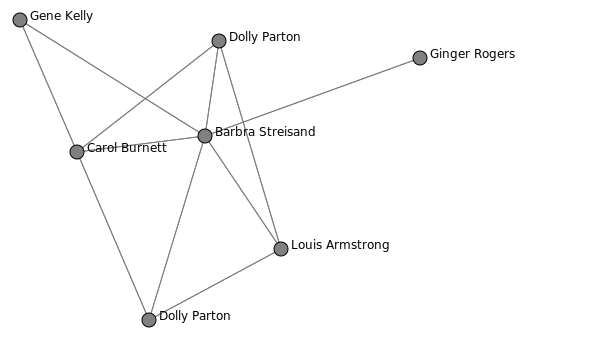

In [462]:
SVG(svg_graph(adjacency[summarized_nodes, :][:, summarized_nodes], names=names[summarized_nodes]))

**Summarized graph: combination of all concepts into one graph**  

All concepts are grouped into one graph to form the **summarized graph**. We analyze connected components in this summarized graph.

In [557]:
%%time

rows, cols = [], []

for c in result:
    
    # exclude first element of lattice 
    if len(c[1]) > 0:
        
        nodes = sorted(c[0])
        
        idx = 0
        idx_nodes = np.zeros(len(nodes)) # number of unique nodes from concepts
        
        # reindex nodes
        for n in nodes:
            if n not in idx_nodes:
                idx_nodes[idx] = n
                idx += 1
            
        # Record edges from subgraph related to concept
        adj_concept = adjacency[nodes, :][:, nodes].tocoo()
        reindex_rows = [int(idx_nodes[src]) for src in adj_concept.row]
        reindex_cols = [int(idx_nodes[dst]) for dst in adj_concept.col]
        rows += reindex_rows
        cols += reindex_cols

CPU times: user 49.1 ms, sys: 2.42 ms, total: 51.5 ms
Wall time: 50.8 ms


In [558]:
summarized_adjacency = sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()
summarized_adjacency

<10011x10011 sparse matrix of type '<class 'numpy.float64'>'
	with 3465 stored elements in Compressed Sparse Row format>

In [559]:
# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))
print(len(mask))

808


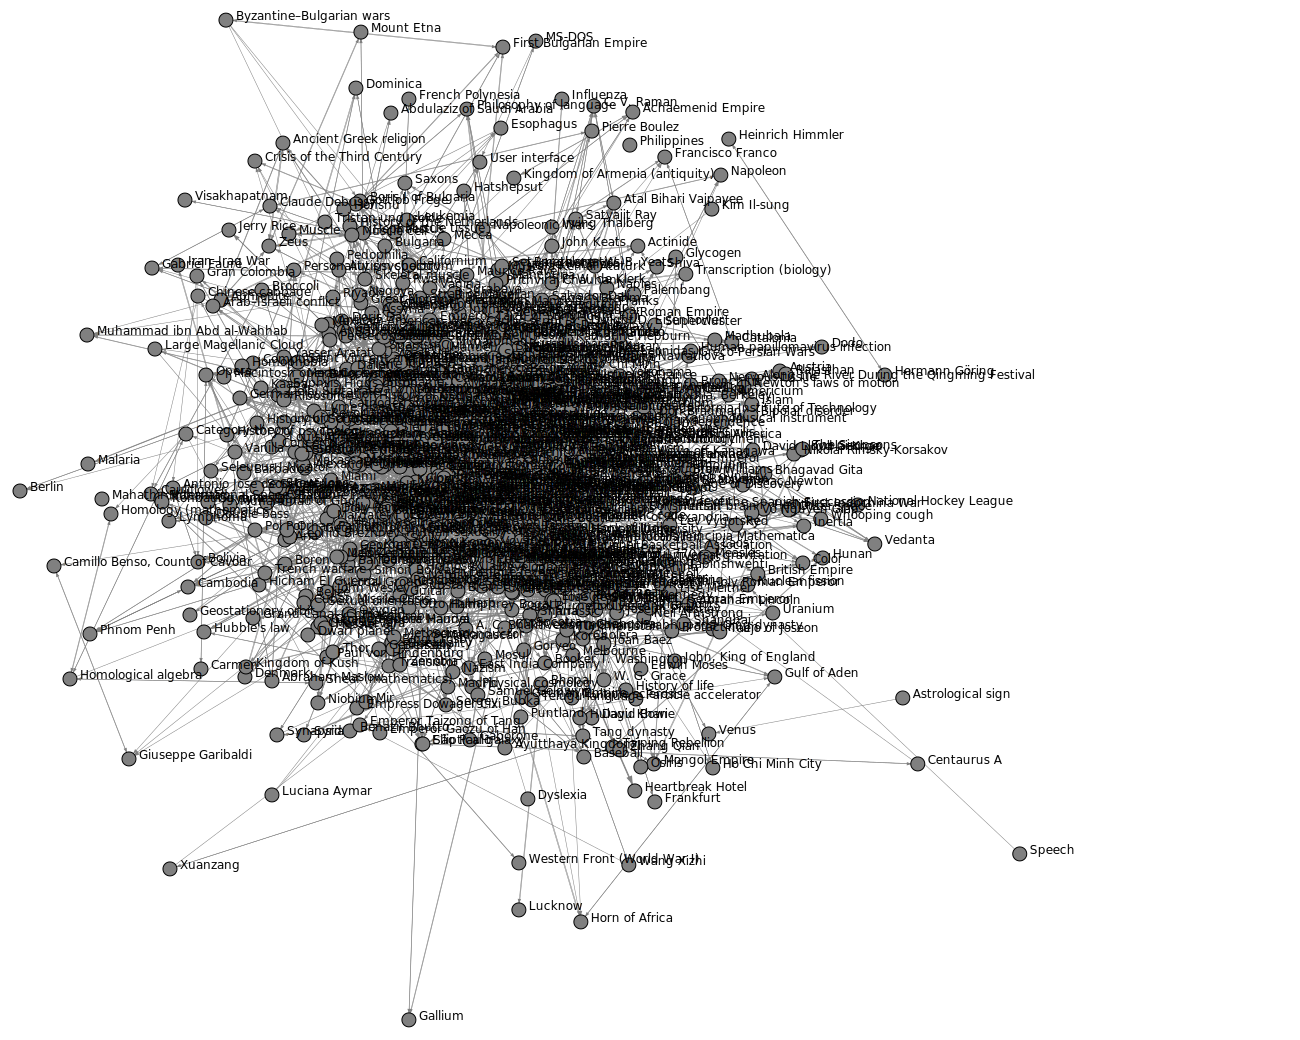

In [563]:
# Summarized graph
SVG(svg_graph(summarized_adjacency[mask, :][:, mask], names=names[mask], 
              edge_width_min=0.5, edge_width_max=2, 
              width=1000, height=1000))

**Connected components in summarized graph**

In [567]:
labels_cc = get_connected_components(adjacency)
Counter(labels_cc)

Counter({0: 10011})

In [580]:
labels_cc_summarized = get_connected_components(summarized_adjacency[mask, :][:, mask])
len(Counter(labels_cc_summarized))

101

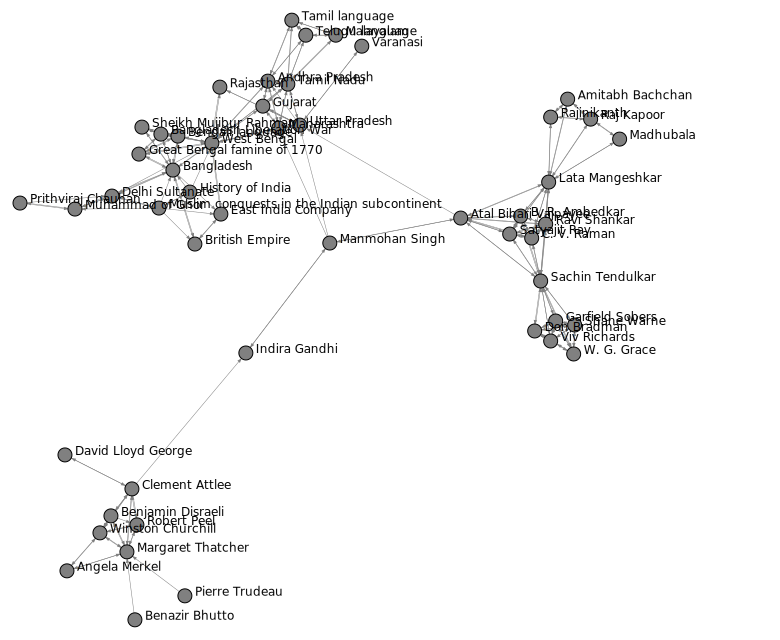

In [594]:
# Find biggest connected component
sorted(Counter(labels_cc_summarized).items(), key=lambda x: x[1], reverse=True)[0]

# Plot connected components
mask_cc = labels_cc_summarized == 14
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc]
SVG(svg_graph(g_cc, names=names[mask][mask_cc], edge_width_min=0.5, edge_width_max=0.5, width=600, height=600))

In [605]:
# Related concepts
concepts = []
g_cc_nodes = mask[mask_cc]

for c in result:
    if len(c[1]) > 0:
        for x in c[0]:
            if x in g_cc_nodes:
                concepts.append(c)
                break
                
print(f'Number of concepts related to biggest connected component: {len(concepts)}')

Number of concepts related to biggest connected component: 25


In [616]:
for c in concepts[:10]:
    print(f'{(str(sorted_names_col[c[1]])):<25} - {(str(names[c[0]]))}')
    print()

['Lok']                   - ['Varanasi' 'Atal Bihari Vajpayee' 'Maharashtra' 'Manmohan Singh'
 'Uttar Pradesh']

['Puducherry']            - ['Telugu language' 'Tamil Nadu' 'Tamil language' 'Malayalam'
 'Andhra Pradesh']

['Filmfare' 'Award']      - ['Lata Mangeshkar' 'Madhubala' 'Raj Kapoor' 'Rajinikanth'
 'Amitabh Bachchan']

['lakh' 'billion']        - ['Bangalore' 'Visakhapatnam' 'West Bengal' 'Rajasthan' 'Uttar Pradesh']

['premiership' 'Prime']   - ['Clement Attlee' 'David Lloyd George' 'Indira Gandhi' 'Mahathir Mohamad'
 'Manmohan Singh']

['Plassey']               - ['Bangladesh' 'East India Company'
 'Muslim conquests in the Indian subcontinent' 'West Bengal'
 'British Empire']

['Nawabs']                - ['Lucknow' 'Bangladesh' 'Bhopal' 'History of India'
 'Muslim conquests in the Indian subcontinent' 'West Bengal']

['Nawabs' 'Delhi']        - ['Lucknow' 'Bangladesh' 'History of India'
 'Muslim conquests in the Indian subcontinent' 'West Bengal']

['Nawabs' 'Mughal']       

**Random connected component in summarized graph**

Number of concepts related to connected component: 2

['Princeton University' 'Yale University'
 'University of California, Berkeley' 'University of Chicago'
 'Harvard University' 'University of Toronto'
 'Massachusetts Institute of Technology' 'Stanford University'] - ['Scholars' 'Fields']

['Princeton University' 'California Institute of Technology'
 'Yale University' 'University of California, Berkeley'
 'University of Cambridge' 'University of Chicago' 'Columbia University'
 'University of Oxford' 'ETH Zurich'
 'Massachusetts Institute of Technology' 'Stanford University'] - ['Medalists' 'Fields']



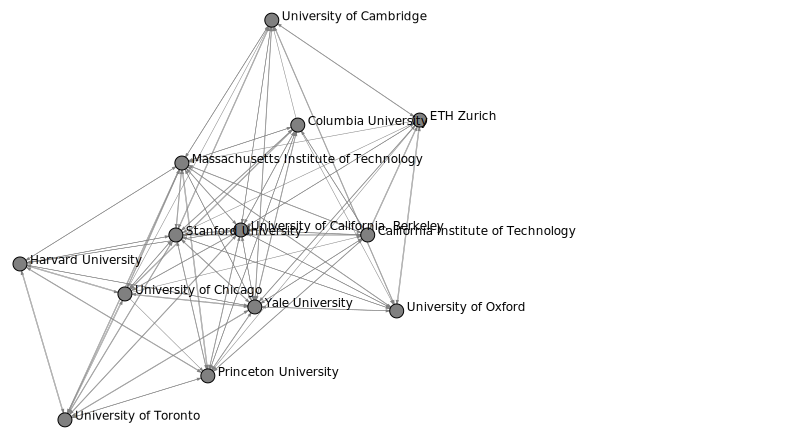

In [683]:
# Find random connected component in summarized graph
con_comps = list(Counter(labels_cc_summarized).items())
idx = np.random.choice(len(con_comps))
random_cc = con_comps[idx]

# Plot connected components
mask_cc = labels_cc_summarized == random_cc[0]
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc]

# Related concepts
concepts = []
g_cc_nodes = mask[mask_cc]

for c in result:
    if len(c[1]) > 0:
        for x in c[0]:
            if x in g_cc_nodes:
                concepts.append(c)
                break
                
print(f'Number of concepts related to connected component: {len(concepts)}')
print()

for c in concepts[:10]:
    print(f'{(str(names[c[0]]))} - {(str(sorted_names_col[c[1]]))}')
    print()
    
SVG(svg_graph(g_cc, names=names[mask][mask_cc], edge_width_min=0.5, edge_width_max=0.5, width=400, height=400))

### Some concepts

['Dolly' 'hello' 'singer']


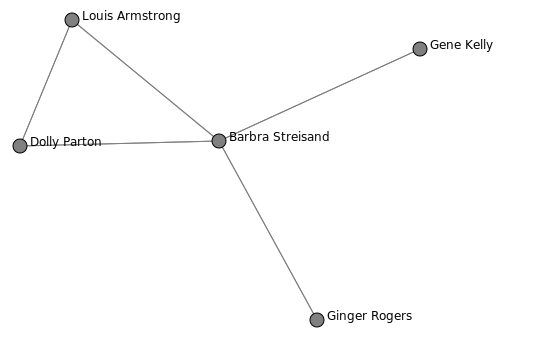

In [298]:
# First graph
objs = np.array([2471, 5418, 3436, 3543,  893])
attrs = np.array([3232, 4409, 16476])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

['monazite' 'earth']


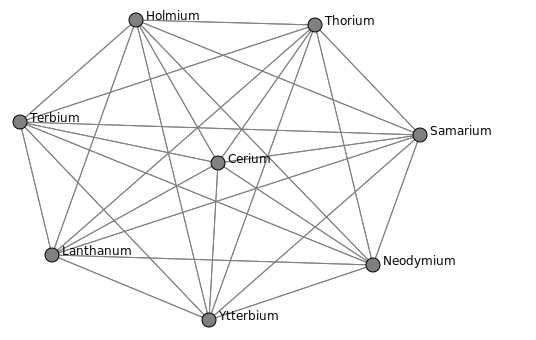

In [299]:
objs = np.array([9094, 4166, 1576, 6317, 9938, 8921, 7900, 5183])
attrs = np.array([5429, 17017])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

['Anschluss' 'Hitler']


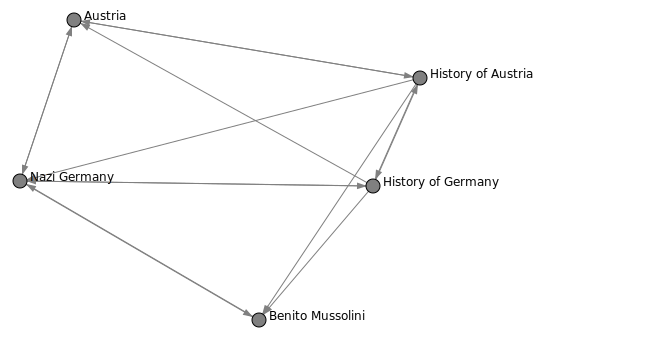

In [347]:
objs = np.array([777, 4078, 1010, 6298, 4063])
attrs = np.array([103, 14319])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

### Random concept

[7745 8098 7500 5360 9427] [ 4458 15323 17130 17803 18016]
['Laureus' 'medal' 'gold' 'final' 'title']


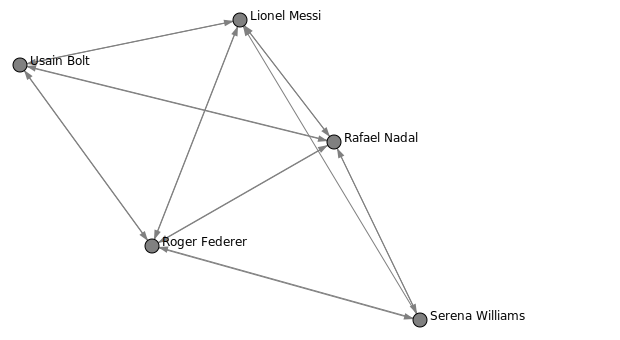

In [387]:
rand_idx = np.random.choice(len(result), 1)
concept = result[rand_idx[0]]
objs, attrs = concept

print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

In [388]:
{i: n for i, n in enumerate(names) if 'Rafael Nadal' in n}

{7500: 'Rafael Nadal'}

**All concepts related to one specific node**

In [401]:
for c in result:
    if 7500 in c[0]:
        print(f'{str(c[1]):>35} - {str(c[0])}')

                                 [] - [    0     1     2 ... 10008 10009 10010]
                        [3983 8801] - [7745 8578 5700 8740 7500 8914 5652]
                   [3983 7224 8801] - [7745 8578 8740 7500 8914 5652]
          [ 4458 15323 17130 18107] - [7745 8098 7500 5360 6224 2675 9427]
                [ 4458 15323 15536] - [8098 7500 5360 6224 2675 9427]
          [ 4458 15323 15536 15796] - [8098 7500 5360 2675 9427]
          [ 4458 15323 15796 17130] - [7745 8098 7500 5360 2675 9427]
          [ 4458 15323 15796 16007] - [7745 8098 7500 5360 9427]
                [ 4458 15323 16007] - [7745 8098 7500 5360 9427]
    [ 4458 15323 17130 17803 18107] - [7745 8098 7500 5360 2675 9427]
    [ 4458 15323 17130 17803 18016] - [7745 8098 7500 5360 9427]
          [ 4458 15323 17130 18004] - [7745 8098 7500 5360 6224]


In [409]:
for c in result:
    if 7500 in c[0]:
        print(f'{str(sorted_names_col[c[1]]):<40}')#' - {names[c[0]]}')

[]                                      
['Wimbledon' 'Slam']                    
['Wimbledon' 'Tennis' 'Slam']           
['Laureus' 'medal' 'gold' 'win']        
['Laureus' 'medal' 'olympic']           
['Laureus' 'medal' 'olympic' 'consecutive']
['Laureus' 'medal' 'consecutive' 'gold']
['Laureus' 'medal' 'consecutive' 'Year']
['Laureus' 'medal' 'Year']              
['Laureus' 'medal' 'gold' 'final' 'win']
['Laureus' 'medal' 'gold' 'final' 'title']
['Laureus' 'medal' 'gold' 'career']     


['Laureus' 'medal' 'Year']


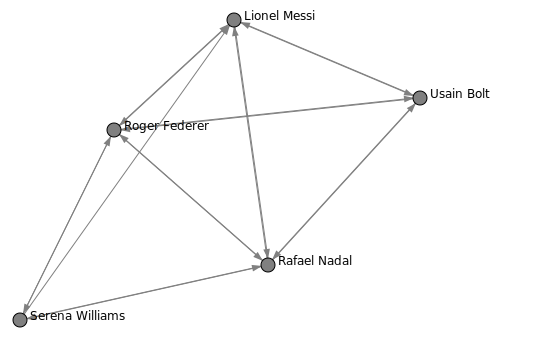

In [414]:
objs = np.array([7745, 8098, 7500, 5360, 9427])
attrs = np.array([4458, 15323, 16007])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

['Wimbledon' 'Slam']


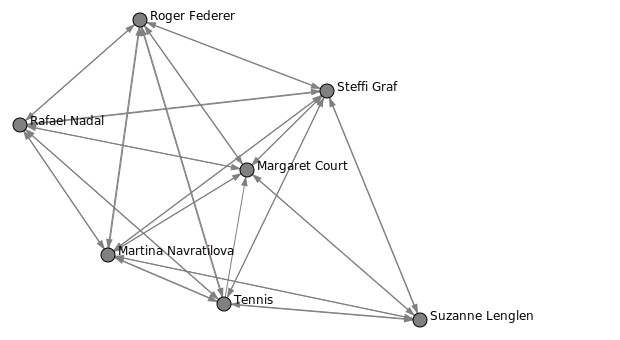

In [411]:
objs = np.array([7745, 8578, 5700, 8740, 7500, 8914, 5652])
attrs = np.array([3983, 8801])

print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs])

SVG(image)

## Quantitative analysis

**Nodes and attributes size distributions in concepts**

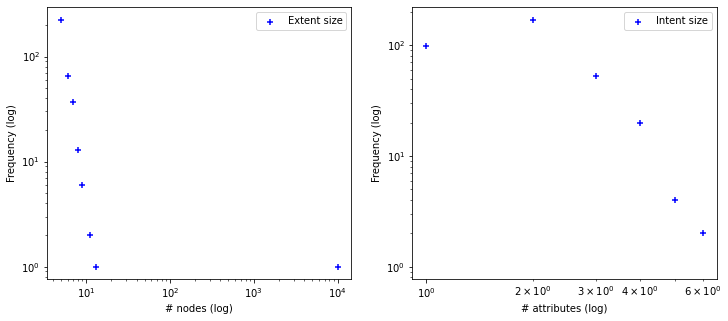

In [334]:
nodes_list, attrs_list = zip(*result)

len_n = map(len, nodes_list)
len_a = map(len, attrs_list)

fig, ax = plt.subplots(1, 2, figsize=(12, 5),)
plot_distrib(Counter(len_n), ax[0], label='Extent size', xlabel='# nodes')
plot_distrib(Counter(len_a), ax[1], label='Intent size', xlabel='# attributes')

### Number of concepts per object

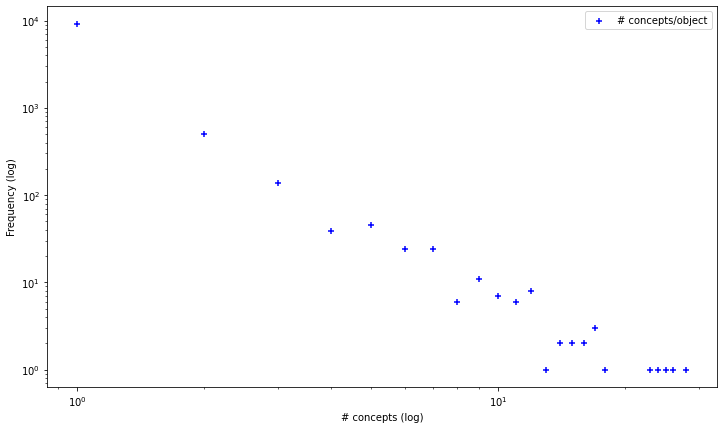

In [418]:
object_concepts = np.zeros(adjacency.shape[0])

for i in range(adjacency.shape[0]):
    for c in result:
        if i in c[0]:
            object_concepts[i] += 1
            
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plot_distrib(object_concepts, ax=ax, label='# concepts/object', xlabel='# concepts')

The majority of objects appear in only 1 concept, but a few objects appear in more than 10 concepts.

In [432]:
# Objects that appear in lots of concepts
for i in np.argsort(-object_concepts)[:10]:
    print(f'Article: {(names[i]):>20} - # of related concepts: {object_concepts[i]}')

Article:  Kareem Abdul-Jabbar - # of related concepts: 28.0
Article:         Lionel Messi - # of related concepts: 26.0
Article:        Magic Johnson - # of related concepts: 25.0
Article:     Wilt Chamberlain - # of related concepts: 24.0
Article:       Michael Jordan - # of related concepts: 23.0
Article:              Eusébio - # of related concepts: 18.0
Article:         LeBron James - # of related concepts: 17.0
Article:    Cristiano Ronaldo - # of related concepts: 17.0
Article:   Alfredo Di Stéfano - # of related concepts: 17.0
Article:        Elvis Presley - # of related concepts: 16.0


In [436]:
# Objects that appear in lots of concepts
for i in np.argsort(-object_concepts)[-10:]:
    print(f'Article: {(names[i]):>30} - # of related concepts: {object_concepts[i]}')

Article:                  Geochronology - # of related concepts: 1.0
Article:                        Geodesy - # of related concepts: 1.0
Article:                 Geodetic datum - # of related concepts: 1.0
Article:               Geoffrey Chaucer - # of related concepts: 1.0
Article:           Geoffrey of Monmouth - # of related concepts: 1.0
Article:   Geographic coordinate system - # of related concepts: 1.0
Article:                      Geography - # of related concepts: 1.0
Article:                          Geoid - # of related concepts: 1.0
Article:    Geological history of Earth - # of related concepts: 1.0
Article:                             −1 - # of related concepts: 1.0


## Annexes
---

In [ ]:
def build_random_graph(n, p):
    edges = []
    lp = np.log(1 - p)
    v = 1
    w = -1
    while v < n:
        lr = np.log(1 - random())
        w = w + 1 + int(lr / lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((w, v))
    
    v = 1
    w = -1   
    while v < n:
        lr = np.log(1 - random())
        w = w + 1 + int(lr / lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((v, w))
    try:
        g = from_edge_list(edges, directed=True, matrix_only=True)
    except ValueError:
        return None

    return g